# Input's Normalization이 AEC 성능에 미치는 영향 확인

In [2]:
import numpy as np
import soundfile as sf

import pandas as pd
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath("../code"))


### Set Algorithm

In [3]:
import AEC_speex as aec

### Adaptation Step이 늦게 수렴하는지 확인하기 위해 data 늘리기
- 1. Vaccum

In [4]:
temp, sr = sf.read("../data/Vaccum/input.wav")

mic = temp[:, 0]
ref = temp[:, 2]

long_mic = np.concatenate([mic, mic, mic, mic, mic])
long_ref = np.concatenate([ref, ref, ref, ref, ref])

In [6]:
aec_speech, aec_echo_short = aec.run_AEC(ref, mic, sr, processor=aec.MDF)
aec_speech, aec_echo_long = aec.run_AEC(long_ref, long_mic, sr, processor=aec.MDF)

s_len = len(mic)
e1 = aec.calculate_erle(mic, aec_echo_short, tag='real')
e2 = aec.calculate_erle(long_mic[-s_len:], aec_echo_long[-s_len:], tag='real')

print(e1, e2)

1.5394695360832997 1.5484105241802233


- Vaccum data는 수렴이 빨리 됨

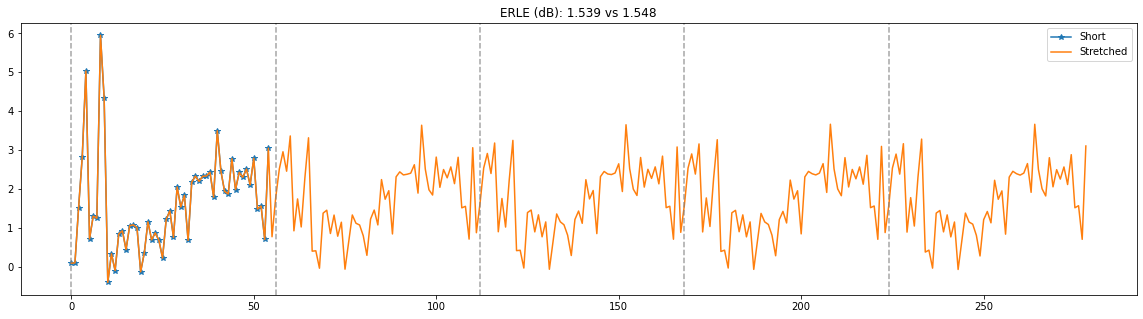

Gain : 0.008940988096923563


In [12]:
# ERLE graph

win_erle_1 = aec.windowed_calculate_erle(mic, aec_echo_short, tag='real')
win_erle_2 = aec.windowed_calculate_erle(long_mic, aec_echo_long, tag='real')

plt.figure(figsize=(20, 5))
plt.plot(win_erle_1, label="Short", marker='*')
plt.plot(win_erle_2, label="Stretched")
plt.legend()

spacing = int(s_len/1024)  # 간격
for xc in range(0, len(win_erle_2), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)
    
plt.title(f"ERLE (dB): {e1:.3f} vs {e2:.3f}")
plt.show()

# Enhancement of ERLE
print(f"Gain : {e2 - e1}")

- 2. RIR mixing data 는 수렴이 늦음

In [19]:
mic, sr = sf.read("../data/Mixing/RIR_mixed.wav")
ref, sr = sf.read("../data/Mixing/RIR_echo.wav")
gt_ref, sr = sf.read("../data/Mixing/echo.wav")

mic = mic[:, 0]
ref = ref[:, 0]
gt_ref = gt_ref[:]

long_mic = np.concatenate([mic, mic, mic, mic, mic])
long_ref = np.concatenate([ref, ref, ref, ref, ref])
long_gt_ref = np.concatenate([gt_ref, gt_ref, gt_ref, gt_ref, gt_ref])

In [20]:
aec_speech, aec_echo_short = aec.run_AEC(gt_ref, mic, sr, processor=aec.MDF)
aec_speech, aec_echo_long = aec.run_AEC(long_gt_ref, long_mic, sr, processor=aec.MDF)

s_len = len(mic)
e1 = aec.calculate_erle(ref, aec_echo_short, tag='simulation')
e2 = aec.calculate_erle(long_ref[-s_len:], aec_echo_long[-s_len:], tag='simulation')

print(e1, e2)

1.8355459630917452 15.572952553146385


- RIR Mixing data는 normalization 영향을 많이 받음

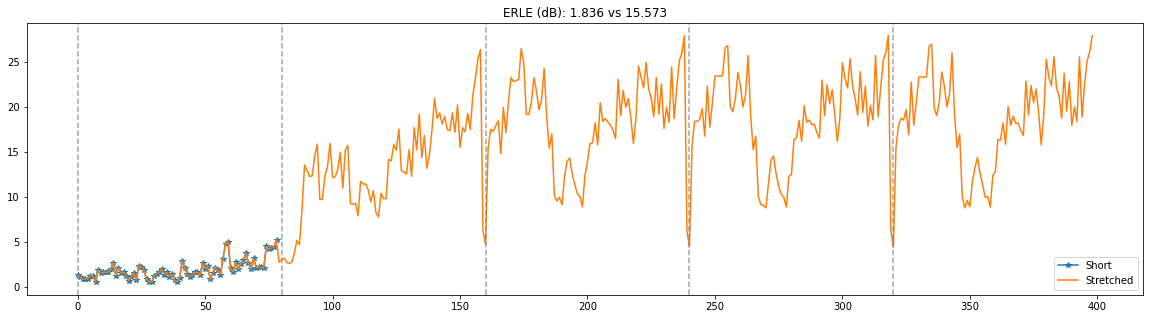

Gain: 13.73740659005464


In [21]:
# ERLE graph

win_erle_1 = aec.windowed_calculate_erle(ref, aec_echo_short, tag='simulation')
win_erle_2 = aec.windowed_calculate_erle(long_ref, aec_echo_long, tag='simulation')

plt.figure(figsize=(20, 5))
plt.plot(win_erle_1, label="Short", marker='*')
plt.plot(win_erle_2, label="Stretched")
plt.legend()

spacing = int(s_len/1024)  # 간격
for xc in range(0, len(win_erle_2), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)

plt.title(f"ERLE (dB): {e1:.3f} vs {e2:.3f}")
plt.show()

# Enhancement of ERLE
print(f"Gain: {e2 - e1}")

# 그럼 그냥 normalization을 해서 넣어주면 어떨까?

In [22]:
# Vaccum data는 효과가 미미하다
temp, sr = sf.read("../data/Vaccum/input.wav")

mic = temp[:, 0]
ref = temp[:, 2]/np.max(temp[:, 2])

long_mic = np.concatenate([mic, mic, mic, mic, mic])
long_ref = np.concatenate([ref, ref, ref, ref, ref])

aec_speech, aec_echo_short = aec.run_AEC(ref, mic, sr, processor=aec.MDF)
aec_speech, aec_echo_long = aec.run_AEC(long_ref, long_mic, sr, processor=aec.MDF)
#--------------------------------------------------------------------------------
s_len = len(mic)
e1 = aec.calculate_erle(mic, aec_echo_short, tag='simulation')
e2 = aec.calculate_erle(long_mic[:-s_len], aec_echo_long[:-s_len], tag='simulation')

print(e1, e2)

1.5414481198428434 1.5680511224770157


In [24]:
# RIR_mixing data는 효과가 크다
mic, sr = sf.read("../data/Mixing/RIR_mixed.wav")
ref, sr = sf.read("../data/Mixing/RIR_echo.wav")
gt_ref, sr = sf.read("../data/Mixing/echo.wav")

mic = mic[:, 0]
ref = ref[:, 0]
gt_ref = gt_ref/np.max(gt_ref)

long_mic = np.concatenate([mic, mic, mic, mic, mic])
long_ref = np.concatenate([ref, ref, ref, ref, ref])
long_gt_ref = np.concatenate([gt_ref, gt_ref, gt_ref, gt_ref, gt_ref])
#--------------------------------------------------------------------------------
aec_speech, aec_echo_short = aec.run_AEC(gt_ref, mic, sr, processor=aec.MDF)
aec_speech, aec_echo_long = aec.run_AEC(long_gt_ref, long_mic, sr, processor=aec.MDF)

s_len = len(mic)
e1 = aec.calculate_erle(ref, aec_echo_short, tag='simulation')
e2 = aec.calculate_erle(long_ref[-s_len:], aec_echo_long[-s_len:], tag='simulation')

print(e1, e2)

13.809843086491494 15.35447253195298


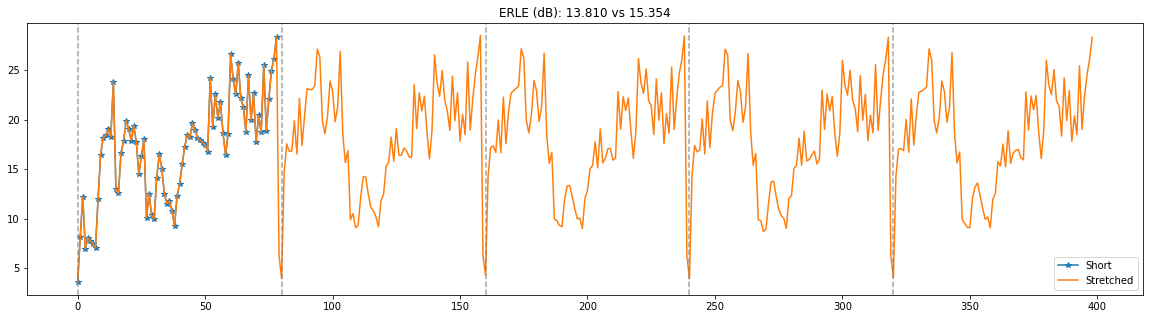

Gain: 1.5446294454614868


In [25]:
# ERLE graph

win_erle_1 = aec.windowed_calculate_erle(ref, aec_echo_short, tag='simulation')
win_erle_2 = aec.windowed_calculate_erle(long_ref, aec_echo_long, tag='simulation')

plt.figure(figsize=(20, 5))
plt.plot(win_erle_1, label="Short", marker='*')
plt.plot(win_erle_2, label="Stretched")
plt.legend()

spacing = int(s_len/1024)  # 간격
for xc in range(0, len(win_erle_2), spacing):
    plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)

plt.title(f"ERLE (dB): {e1:.3f} vs {e2:.3f}")
plt.show()

# Enhancement of ERLE
print(f"Gain: {e2 - e1}")

# NEXT:: Converged filter를 Init Filter로 사용해볼까?
### ... 라고 생각했지만, Dynamite mixing 같은 경우 RIR을 mic와 가까이 놓고 RIR generate한 게 아니라서 애초애 `잘못 Mixing`된 데이터를 갖고 실험한거다.. 엉망진창이어서 Mixing부터 다시했다